# Spam Vs Ham Classifier

This notebook corresponds to excercise #4 of the book, we will use the Apache Spam assasing corpus https://spamassassin.apache.org/old/publiccorpus/.

I'm going to work with:
* 20021010_spam.tar.bz2 (Contains emails flagged as spam)
* 20021010_easy_ham.tar.bz2 (Contains easily recognizable ham emails)
* 20021010_hard_ham.tar.bz2 (Contains ham emails but can be mistaken with spam)

## Data exploration
Let's see the content of these folders.


In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_URL = "http://spamassassin.apache.org/old/publiccorpus/"
#HAM_URL = DOWNLOAD_URL + "20021010_easy_ham.tar.bz2"
#SPAM_URL = DOWNLOAD_URL + "20021010_spam.tar.bz2"
HAM_URL = DOWNLOAD_URL + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_URL + "20030228_spam_2.tar.bz2"

DATASETS_PATH = os.path.join('./', 'spamham')

def fetch_data(files, datasets_path=DATASETS_PATH):
    if not files:
        raise ValueError("You must provide the files to download")
    
    if type(files) != tuple:
        if type(files) == list and type(files[0]) != tuple:
            raise ValueError("The files must be a tuple or list of tuples e.g.: ('filename', 'url') or [('filename', 'url')]")
                
    if not os.path.isdir(datasets_path):
        os.makedirs(datasets_path)
        
    for filename, url in files:
        path = os.path.join(datasets_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=DATASETS_PATH)
        tar_bz2_file.close()

In [2]:
files = [
    ('ham.tar.bz2', HAM_URL),
    ('spam.tar.bz2', SPAM_URL)
]

fetch_data(files)

In [3]:
HAM_DIR = os.path.join(DATASETS_PATH, 'easy_ham')
SPAM_DIR = os.path.join(DATASETS_PATH, 'spam_2')

ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [4]:
print("Ham samples: ", len(ham_filenames))
print("Spam samples: ", len(spam_filenames))

Ham samples:  2500
Spam samples:  1397


In [5]:
import email
import email.policy

def load_email(is_spam, filename, path=DATASETS_PATH):
    directory = 'spam_2' if is_spam else 'easy_ham'
    with open(os.path.join(DATASETS_PATH, directory, filename), 'rb') as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [6]:
ham_emails = [load_email(False, name) for name in ham_filenames]
spam_emails = [load_email(True, name) for name in spam_filenames]

### This is a ham email

In [7]:
print(ham_emails[0].get_content().strip())

Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ...

delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55:56 

### Now this is a spam

In [8]:
print(spam_emails[6].get_content().strip())

NEW PRODUCT ANNOUNCEMENT

From: OUTSOURCE ENG.& MFG. INC.


Sir/Madam;

This note is to inform you of new watchdog board technology for maintaining
continuous unattended operation of PC/Servers etc. that we have released for
distribution.
  
We are proud to announce Watchdog Control Center featuring MAM (Multiple
Applications Monitor) capability.
The key feature of this application enables you to monitor as many
applications as you
have resident on any computer as well as the operating system for
continuous unattended operation.  The Watchdog Control Center featuring
MAM capability expands third party application "control" of a Watchdog as
access to the application's
source code is no longer needed.

Here is how it all works:
Upon installation of the application and Watchdog, the user may select
many configuration options, based on their model of Watchdog, to fit their
operational needs.  If the MAM feature is enabled, the user may select any
executable program that they wish for monit

### Email structures
Emails can have different structures, some might contain attachments, and attached emails that might also contain attachments. Let's decompose the email structures.

In [9]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email) for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [10]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [11]:
ham_structure_count = structures_counter(ham_emails).most_common()
ham_structure_count

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [12]:
spam_structure_count = structures_counter(spam_emails).most_common()
spam_structure_count

[('text/plain', 598),
 ('text/html', 589),
 ('multipart(text/plain, text/html)', 114),
 ('multipart(text/html)', 29),
 ('multipart(text/plain)', 25),
 ('multipart(multipart(text/html))', 18),
 ('multipart(multipart(text/plain, text/html))', 5),
 ('multipart(text/plain, application/octet-stream, text/plain)', 3),
 ('multipart(text/html, text/plain)', 2),
 ('multipart(text/html, image/jpeg)', 2),
 ('multipart(multipart(text/plain), application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/jpeg, image/jpeg, image/jpeg, image/jpeg)',
  1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/jpeg, image/jpeg, image/jpeg, image/gif)',
  1),
 ('text/plain charset=us-ascii', 1),
 ('multipart(multipart(text/html), image/gif)', 1),
 ('multipart(multipart(text/plain, text/html), application/octet-stream, application/octet-stream, applic

It seems the proportion of text/plan vs text/html is significantly different. Spam emails tend to be more on the text/html side. Also, ham emails tend to use pgp-signature while none of the spam emails uses one. This might be a useful attribute.

In [13]:
import numpy as np

ham_structures = np.array([[pair[0], pair[1]] for pair in ham_structure_count])
spam_structures = np.array([[pair[0], pair[1]] for pair in spam_structure_count])

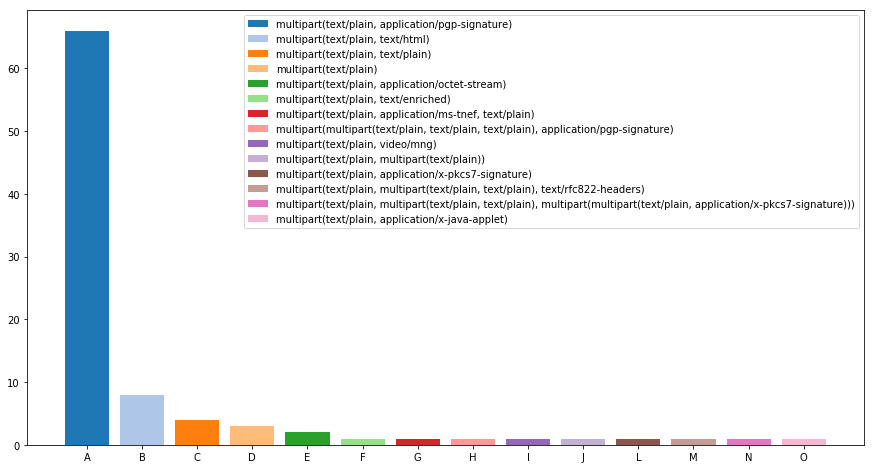

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

# Omit the first class as the proportion won't allow to see the rest
ham_struct_types = ham_structures[1:,0]
ham_struct_counts = ham_structures[1:,1].astype(np.int)

classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "L", "M", "N", "O"]
prop_iter = iter(plt.cm.tab20.colors)

plt.figure(figsize=(15, 8))
legends = []
for t, c, l in zip(classes, ham_struct_counts, ham_struct_types):
    bar = plt.bar(t, c, color=next(prop_iter), label=l)
    legends.append(bar)
plt.legend(handles=legends)
plt.show()

In the above plot, I have omitted the text/plain class as the amount surpasses significantly the others and mekes them hard to see. From this chart, we can observe that among ham, the most frequent class other than plain/text is the one that uses pgp-signature.

Now, let's observe what happens with the spam.

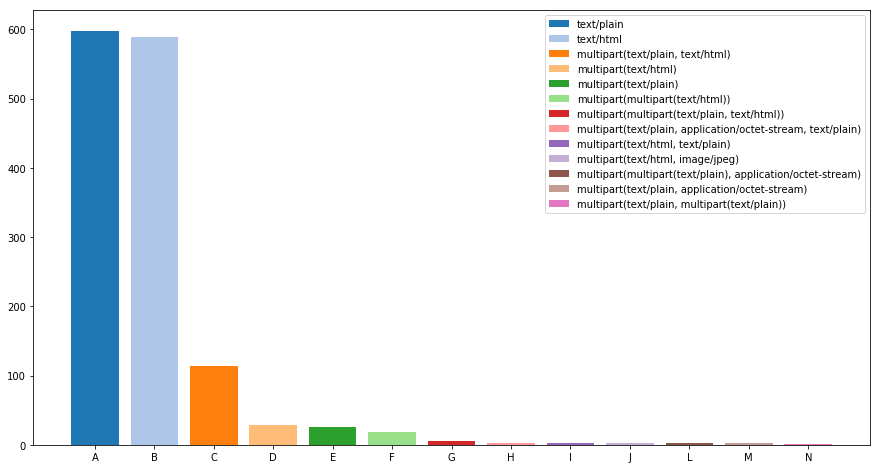

In [15]:
spam_struct_types = spam_structures[0:,0]
spam_struct_counts = spam_structures[0:,1].astype(np.int)

classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "L", "M", "N"]
prop_iter = iter(plt.cm.tab20.colors)

plt.figure(figsize=(15, 8))
legends = []
for t, c, l in zip(classes, spam_struct_counts, spam_struct_types):
    bar = plt.bar(t, c, color=next(prop_iter), label=l)
    legends.append(bar)
plt.legend(handles=legends)
plt.show()

On Spam, we observe that there is no signature type emails, the highest ones are text/plain and text/html.

### Email headers

In [16]:
for header, value in spam_emails[1].items():
    print(header, ":", value)

Return-Path : merchantsworld2001@juno.com
Delivery-Date : Mon May 13 04:46:13 2002
Received : from mandark.labs.netnoteinc.com ([213.105.180.140]) by    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g4D3kCe15097 for    <jm@jmason.org>; Mon, 13 May 2002 04:46:12 +0100
Received : from 203.129.205.5.205.129.203.in-addr.arpa ([203.129.205.5]) by    mandark.labs.netnoteinc.com (8.11.2/8.11.2) with SMTP id g4D3k2D12605 for    <jm@netnoteinc.com>; Mon, 13 May 2002 04:46:04 +0100
Received : from html (unverified [207.95.174.49]) by    203.129.205.5.205.129.203.in-addr.arpa (EMWAC SMTPRS 0.83) with SMTP id    <B0000178595@203.129.205.5.205.129.203.in-addr.arpa>; Mon, 13 May 2002    09:04:46 +0530
Message-Id : <B0000178595@203.129.205.5.205.129.203.in-addr.arpa>
From : lmrn@mailexcite.com
To : ranmoore@cybertime.net
Subject : Real Protection, Stun Guns!  Free Shipping! Time:2:01:35 PM
Date : Mon, 28 Jul 1980 14:01:35 -0000
MIME-Version : 1.0
X-Keywords : 
Content-Type : text/html; charset="D

Probably, there is useful information here, like the sender, this kind of email, 'Life Insurance - Why Pay More?' looks suspicuous.

In [17]:
spam_emails[1]["Subject"]

'Real Protection, Stun Guns!  Free Shipping! Time:2:01:35 PM'

### Train/Test Split

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Preprocessing
We would want to convert HTML emails into plain/text. The original author's solutions creates regex based parsers but suggest BeautifulSoup as an alternative. I'm going to use this library for the sake of learning!

Ref
* https://www.crummy.com/software/BeautifulSoup/bs4/doc/

In [19]:
#From X_train get all where the indexes has a y_train==1
html_spam_emails = [email for email in X_train[y_train==1] if get_email_structure(email) == "text/html"]
html_sample = html_spam_emails[0].get_content().strip()

This is a spam sample in HTML form

In [20]:
print(html_sample[:1000], '...')

<HTML>
<HEAD>
<TITLE>Full Access Medical</TITLE>
<META HTTP-EQUIV="Content-Type" CONTENT="text/html; charset=iso-8859-1">
</HEAD>
<BODY BGCOLOR=#FFFFFF>
<div align="center"><a href="http://65.162.84.5/perl/050902_02.pl"><img src="http://65.162.84.5/images/fam_email19.jpg" width="380" height="380" border="0"></a></div>
<TABLE WIDTH=380 BORDER=0 CELLPADDING=0 CELLSPACING=0 align="center">
  <tr> 
      <TD COLSPAN=3> 
        <hr>
        <font face="Verdana, Arial, Helvetica, sans-serif" size=1><br>
          To sign up for the Full Access Medical, LLC Plan the applicant must 
          be at least 18 and pay a one-time enrollment fee of  regardless of 
          the number of dependents enrolled. This non-insurance healthcare plan 
          is not available in Washington.</font>
    </td>
  </tr>
</TABLE>

<p><font size=-1 color=black>This email is not sent unsolicited. You are receiving it because you requested receive this email by opting-in with our marketing partner. You will rece

Let's take a look at one of the HTML emails using the IPython display

In [21]:
import IPython
IPython.display.HTML(html_sample)

"To sign up for the Full Access Medical, LLC Plan the applicant must be at least 18 and pay a one-time enrollment fee of regardless of the number of dependents enrolled. This non-insurance healthcare plan is not available in Washington."


Now, the goal is strip down all the HTML tags and just stay with the text. The rules:

* All head tags must me removed
* All links, i.e., ```<a>``` tags, must be repladed with the word 'HYPERLINK'
* All HTML tags must be stripped, i.e., Remove all the ```<whathever/>```
* Remove all the HTML escape characters such as ```&gt;```, ```&nbsp;```

Fortunately, it seems that Beautiful Soup makes very easy to navigate all the HTML tree effortlessly, so this is just a matter of picking the information as needed.

In [22]:
from bs4 import BeautifulSoup
import re

def html_to_plain_text(email):
    soup = BeautifulSoup(email, 'html.parser')
    for link in soup.findAll('a'):
        link.replace_with(' HYPERLINK ' + link.getText())
    text = soup.getText().strip()
    #https://docs.python.org/3.5/library/re.html#re.sub
    text = re.sub(r'(\s*\n+)', '\n', text, flags=re.M | re.S) # r.M (multiline), r.S (dot matches all)
    return text

In [23]:
print(html_to_plain_text(html_sample))

Full Access Medical
 HYPERLINK
          To sign up for the Full Access Medical, LLC Plan the applicant must
          be at least 18 and pay a one-time enrollment fee of  regardless of
          the number of dependents enrolled. This non-insurance healthcare plan
          is not available in Washington.
This email is not sent unsolicited. You are receiving it because you requested receive this email by opting-in with our marketing partner. You will receive notices of exciting offers, products, and other options! However, we are committed to only sending to those people that desire these offers. If you do not wish to receive such offers
 HYPERLINK Click Here. or paste the following into any browser: http://65.162.84.5/perl/unsubscribe.pl?s=20020510190852000001230835  to remove your email name from our list. You may contact our company by mail at 1323 S.E. 17th Street, Suite Number 345, Ft. Lauderdale, Fl 33316


Now, a function that takes an email and returns the text regardless of the input type/structure

In [24]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ('text/plain', 'text/html'):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == 'text/plain':
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [25]:
print(email_to_text(html_spam_emails[0])[:100], '...')

Full Access Medical
 HYPERLINK
          To sign up for the Full Access Medical, LLC Plan the applic ...


Works good!

Now, we need to do some NLP, for this we will need to install ```nltk```

In [26]:
from nltk import PorterStemmer

stemmer = PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
    print(word, '=>', stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


Now let's detect the urls. For this we will use ```urlextract``` which will simple extract from a given text, anything that is a url.

In [27]:
import os
import sys
sys.path

['',
 '/Users/ferro/anaconda3/envs/Deeplearning/lib/python36.zip',
 '/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6',
 '/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/lib-dynload',
 '/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages',
 '/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/IPython/extensions',
 '/Users/ferro/.ipython']

In [28]:
from urlextract import URLExtract

url_extractor = URLExtract()
print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


Now we'll need to put all this togheter and build the transformers.

**Note:** Here we are just using space split for separating the words then counting them, however, Asian languages (Chinese, Japanese and Vietnamese) don't follow the same conventions to separate words hence this approach is not general. This dataset is mostly english language, hence we are okay with it.

In [101]:
from sklearn.base import BaseEstimator, TransformerMixin

class Email2WordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            # if email_to_text(email) evaluates to a falsy value, then "" is assigned to text,
            # otherwise the value of email_to_text(email)
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            ## Assuming url_extractor is already instantiated
            if self.replace_urls and url_extractor is not None:
                try:
                    urls = list(set(url_extractor.find_urls(text)))
                    urls.sort(key=lambda url: len(url), reverse=True)
                    ## Replace all the urls with the word 'URL'
                    for url in urls:
                        text = text.replace(url, " URL ")
                except AttributeError:
                    pass
            if self.replace_numbers:
                ## Basically replace all the numbers with the word 'NUMBER'
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                ## Remove everything that is not a word, apply multiline
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            ## Assumming the stemmer is already instantiated
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Let's test it

In [102]:
X_few = X_train[:3]
X_few_wordcounts = Email2WordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'number': 8, 'to': 4, 'a': 4, 'the': 4, 'url': 2, 'ubi': 2, 'china': 2, 'for': 2, 'local': 2, 'date': 1, 'numbertnumb': 1, 'had': 1, 'alway': 1, 'want': 1, 'make': 1, 'pc': 1, 'game': 1, 'market': 1, 'but': 1, 'factor': 1, 'kept': 1, 'idea': 1, 'on': 1, 'hold': 1, 'in': 1, 'januari': 1, 'right': 1, 'incent': 1, 'motiv': 1, 'tri': 1, 'project': 1, 'final': 1, 'arriv': 1, 'licens': 1, 'music': 1, 'up': 1, 'popular': 1, 'anim': 1, 'properti': 1}),
       Counter({'number': 11, 'to': 5, 'you': 5, 'the': 4, 'of': 4, 'receiv': 4, 'thi': 3, 'not': 3, 'email': 3, 'our': 3, 'offer': 3, 'full': 2, 'access': 2, 'medic': 2, 'hyperlink': 2, 'plan': 2, 'at': 2, 'and': 2, 'enrol': 2, 'is': 2, 'in': 2, 'are': 2, 'by': 2, 's': 2, 'sign': 1, 'up': 1, 'for': 1, 'llc': 1, 'applic': 1, 'must': 1, 'be': 1, 'least': 1, 'pay': 1, 'a': 1, 'one': 1, 'time': 1, 'fee': 1, 'regardless': 1, 'depend': 1, 'non': 1, 'insur': 1, 'healthcar': 1, 'avail': 1, 'washington': 1, 'sent': 1, 'unsolicit': 1, 'it

Now we must convert this into a vector, basically we will build a matrix for which each column represents a word and the value in each cell represents the occurrences of this word in the sample. We will end up with a sparse matrix, i.e., a lot of zeros and a few cells with actual values.

We will create another transformer, this time we will implement the ```fit``` method, as the first purpose is to build a vocabulary from the word counts. Then the ```transform``` method will transform the data into this vocabulary.

In [103]:
from scipy.sparse import csr_matrix

class WordCounter2VectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        ## iterate over each sample in X
        for word_count in X:
            for word, count in word_count.items():
                ## keep track of how many times the word appears. I'm not sure why the author has a threshold of 10, perhaps to prevent a explosion of frequencies?
                #total_count[word] += min(count, 10)
                total_count[word] += count
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [104]:
vocab_transformer = WordCounter2VectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 29 stored elements in Compressed Sparse Row format>

In [105]:
X_few_vectors.toarray()

array([[ 35,   8,   4,   4,   0,   4,   2,   0,   2,   1,   0],
       [117,  11,   5,   4,   4,   1,   1,   1,   0,   2,   5],
       [230,  21,   9,   9,  10,   6,   6,   7,   5,   4,   2]],
      dtype=int64)

In [106]:
vocab_transformer.vocabulary_

{'number': 1,
 'to': 2,
 'the': 3,
 'of': 4,
 'a': 5,
 'for': 6,
 'that': 7,
 'url': 8,
 'in': 9,
 'you': 10}

Now let's train a spam classifier

In [107]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", Email2WordCounterTransformer()),
    ("wordcount_to_vector", WordCounter2VectorTransformer())
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.9740134744947064, total=   0.1s
[CV]  ................................................................
[CV] ....................... , score=0.9894128970163619, total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ........................ , score=0.983638113570741, total=   0.4s


/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished


0.9823548283606032

In [109]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.fit_transform(X_test)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_train_pred = log_clf.predict(X_train_transformed)
y_test_pred = log_clf.predict(X_test_transformed)

train_precision = 100 * precision_score(y_train, y_train_pred)
train_recall = 100 *recall_score(y_train, y_train_pred)

test_precision = 100 * precision_score(y_test, y_test_pred)
test_recall = 100 *recall_score(y_test, y_test_pred)

print("Train Precision Score: {:.2f}%".format(train_precision))
print("Train Recall Score: {:.2f}%".format(train_recall))
print("Test Precision Score: {:.2f}%".format(test_precision))
print("Test Recall Score: {:.2f}%".format(test_recall))

Train Precision Score: 100.00%
Train Recall Score: 99.19%
Test Precision Score: 66.01%
Test Recall Score: 47.18%


Contrary to the author's example, I'm getting far worse performance in the test set. And taking a look at the training score, it seems I'm falling into overfitting.

# Extras
Zone for testing specific parts of the notebook to see how the algorithms are working.

## Getting the most common words

### References
Counters: https://pymotw.com/2/collections/counter.html

In [ ]:
total_count = Counter()
vocabulary_size = 10
## iterate over each sample in X
for word_count in X_few_wordcounts:
    for word, count in word_count.items():
        ## keep track of how many times the word appears. I'm not sure why the author has a threshold of 10, perhaps to prevent a explosion of frequencies?
        total_count[word] += min(count, 10)
        #total_count[word] += count
# Counter.most_common() simply will order by count and return a list of tuples with the most frequent words at the top with the count also.
most_common = total_count.most_common()[:vocabulary_size]
vocabulary = {word: index + 1 for index, (word, count) in enumerate(most_common)}

In [ ]:
total_count.most_common()[:10]